In [1]:
from rich import print

%load_ext rich

In [2]:
import urllib

import einops
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm


In [3]:
import mlflow

In [4]:
mlflow.set_tracking_uri("http://localhost:5000")

In [ ]:
mlflow.set_experiment("check-localhost-connection")

with mlflow.start_run():
    mlflow.log_metric("foo", 1)
    mlflow.log_metric("bar", 2)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
torch.set_default_device(device)

# DDPM: Denoising Diffusion Probabilistic Models


## Load dataset

In [7]:
IMAGE_SIZE = (28, 28)
BATCH_SIZE = 128

In [30]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 2 - 1),
    ]
)

reverse_transform = transforms.Compose(
    [
        transforms.Lambda(lambda x: (x + 1) / 2),
        transforms.ToPILImage(),
    ]
)


In [31]:
data = torchvision.datasets.CelebA(
    root="data", split="train", download=True, transform=transform
)


loader = torch.utils.data.DataLoader(
    data, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device)
)

Files already downloaded and verified


In [39]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    fig = plt.figure(figsize=(8, 8))
    rows = int(np.ceil(len(images) / 8))
    cols = 8

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis("off")
            ax.set_adjustable("box")  # Reduce plot spacing

            if idx < len(images):
                plt.imshow(reverse_transform(images[idx]))
                idx += 1

    fig.suptitle(title, fontsize=12)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce plot spacing
    plt.tight_layout()
    plt.show()


# Shows the first batch of images
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0][:32], "Images in the first batch")
        break

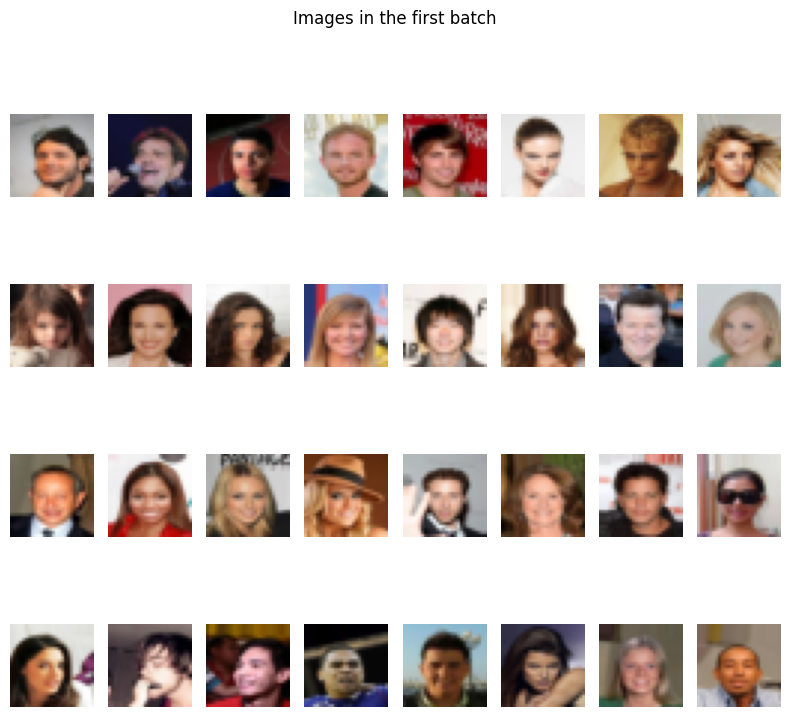

In [40]:
show_first_batch(loader)

## Forward pass - adding noise to image

- $\beta_t$ represents the noise added at timestep $t$.
- $\alpha_t = 1-\beta_t$ represents the amount of original image information that is preserved at timestep $t$
- $\bar\alpha_t$ is the cumulative product of $\alpha$, i.e., $\bar\alpha=\prod_{i=1}^t \alpha_i$

The output image at timestep $t$ is given by:
$$
x_t = \sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar\alpha_t}\epsilon_t
$$

where $x_0$ is the original image and $\epsilon_t$ is the noise added at timestep $t$.

In [41]:
class ForwardDiffusion(nn.Module):
    def __init__(self, min_beta=10**-4, max_beta=0.02, n_steps=200):
        super().__init__()
        self.betas = torch.linspace(min_beta, max_beta, n_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor(
            [torch.prod(self.alphas[: i + 1]) for i in range(len(self.alphas))]
        )
        self.n_steps = n_steps

    def forward(self, x0, t, eta=None):
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t].reshape(n, 1, 1, 1)

        if eta is None:
            eta = torch.randn(n, c, h, w)

        x_out = a_bar.sqrt() * x0 + (1 - a_bar).sqrt() * eta
        return x_out

In [42]:
import ipywidgets as widgets
from IPython.display import display


def show_forward(ddpm, loader):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0][:32]
        imgs = imgs.to(device)

        # Create a list to hold the images and titles
        images = [imgs]
        titles = ["Original images"]

        for percent in [0.25, 0.5, 0.75, 1]:
            noisy_images = ddpm(
                imgs,
                [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))],
            )
            images.append(noisy_images)
            titles.append(f"{int(percent * 100)}%")

        # Create tabs for each set of images
        tabs = widgets.Tab()
        children = []
        for img_set, title in zip(images, titles):
            output = widgets.Output()
            with output:
                show_images(img_set, title)
            children.append(output)

        tabs.children = children
        for i, title in enumerate(titles):
            tabs.set_title(i, title)

        display(tabs)

        break


In [43]:
fwd_diff = ForwardDiffusion()
show_forward(fwd_diff, loader)

## Backward pass - denoising

In [44]:
class Diffusion(nn.Module):
    def __init__(self, network, min_beta=10**-4, max_beta=0.02, n_steps=200):
        super().__init__()

        self.network = network
        self.betas = torch.linspace(min_beta, max_beta, n_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor(
            [torch.prod(self.alphas[: i + 1]) for i in range(len(self.alphas))]
        )
        self.n_steps = n_steps

    def forward(self, x0, t, eta=None):
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t].reshape(n, 1, 1, 1)

        if eta is None:
            eta = torch.randn(n, c, h, w)

        x_out = a_bar.sqrt() * x0 + (1 - a_bar).sqrt() * eta
        return x_out

    def backward(self, x, t):
        """
        Computes the backward pass of the diffusion model and estimates the noise added
        """
        return self.network(x, t)

### Generate

In [58]:
def generate_new_images(
    ddpm,
    n_samples=16,
    c=1,
    h=28,
    w=28,
    frames_per_gif=100,
    gif_name="images/sampling.gif",
):
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        x = torch.randn(n_samples, c, h, w)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            time_t = (torch.ones(n_samples, 1) * t).long()
            eta_theta = ddpm.backward(x, time_t)

            alpha_t = ddpm.alphas[t]
            alpha_bar_t = ddpm.alpha_bars[t]

            # Partial denoising
            x = (1 / alpha_t.sqrt()) * (
                x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * eta_theta
            )

            if t > 0:
                z = torch.randn(n_samples, c, h, w)

                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                x = x + sigma_t * z

                # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(
                    normalized,
                    "(b1 b2) c h w -> (b1 h) (b2 w) c",
                    b1=int(n_samples**0.5),
                )
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

## UNet


### ResidualBlock

In [46]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        shape,
        in_channels,
        out_channels,
        kernel_size=3,
        padding=1,
        stride=1,
        activation=None,
        normalize=True,
    ):
        super(ResidualBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size, padding=padding, stride=stride
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size, padding=padding, stride=stride
        )
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)

        return out

### Positional Embedding

In [47]:
def sinusodial_embedding(n, d):
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))

    t = torch.arange(n).reshape((n, 1))
    embedding[:, ::2] = torch.sin(t * wk[:, ::2])
    embedding[:, 1::2] = torch.cos(t * wk[:, 1::2])

    return embedding


In [48]:
def time_mlp(self, d_in, d_out):
    return nn.Sequential(
        nn.Linear(d_in, d_out),
        nn.SiLU(),
        nn.Linear(d_out, d_out),
    )

In [54]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, d_time=100):
        super(UNet, self).__init__()

        # Sinsusodial embedding
        self.time_embed = nn.Embedding(n_steps, d_time)
        self.time_embed.weight.data = self.sinusodial_embedding(n_steps, d_time)
        self.time_embed.weight.requires_grad_(False)

        # Encoder
        # ----------------------------
        # Layer 1
        self.time_1 = self.time_mlp(d_time, 3)
        self.batch_1 = nn.Sequential(
            ResidualBlock((3, 28, 28), 3, 10),
            ResidualBlock((10, 28, 28), 10, 10),
            ResidualBlock((10, 28, 28), 10, 10),
        )
        # 10 x 28 x 28 -> 10 x 14 x 14
        self.down_1 = nn.Conv2d(
            in_channels=10, out_channels=10, kernel_size=4, stride=2, padding=1
        )

        # Layer 2
        self.time_2 = self.time_mlp(d_time, 10)
        self.batch_2 = nn.Sequential(
            ResidualBlock((10, 14, 14), 10, 20),
            ResidualBlock((20, 14, 14), 20, 20),
            ResidualBlock((20, 14, 14), 20, 20),
        )
        # 20 x 14 x 14 -> 20 x 7 x 7
        self.down_2 = nn.Conv2d(
            in_channels=20, out_channels=20, kernel_size=4, stride=2, padding=1
        )

        # Layer 3
        self.time_3 = self.time_mlp(d_time, 20)
        self.batch_3 = nn.Sequential(
            ResidualBlock((20, 7, 7), 20, 40),
            ResidualBlock((40, 7, 7), 40, 40),
            ResidualBlock((40, 7, 7), 40, 40),
        )
        # 40 x 7 x 7 -> 40 x 4 x 4
        self.down_3 = nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=40, kernel_size=2, stride=1),
            nn.SiLU(),
            nn.Conv2d(
                in_channels=40, out_channels=40, kernel_size=4, stride=2, padding=1
            ),
        )

        # Bottleneck
        # ----------------------------
        self.time_bottleneck = self.time_mlp(d_time, 40)
        self.batch_mid = nn.Sequential(
            ResidualBlock((40, 3, 3), 40, 20),
            ResidualBlock((20, 3, 3), 20, 20),
            ResidualBlock((20, 3, 3), 20, 40),
        )

        # Decoder
        # ----------------------------

        # 40 x 4 x 4 -> 40 x 8 x 8
        self.up_3 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.time_4 = self.time_mlp(d_time, 80)
        self.batch_4 = nn.Sequential(
            ResidualBlock((80, 7, 7), 80, 40),
            ResidualBlock((40, 7, 7), 40, 20),
            ResidualBlock((20, 7, 7), 20, 20),
        )

        # 20 x 8 x 8 -> 20 x 16 x 16
        self.up_2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.time_5 = self.time_mlp(d_time, 40)
        self.batch_5 = nn.Sequential(
            ResidualBlock((40, 14, 14), 40, 20),
            ResidualBlock((20, 14, 14), 20, 10),
            ResidualBlock((10, 14, 14), 10, 10),
        )

        # 10 x 16 x 16 -> 10 x 28 x 28
        self.up_1 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.time_out = self.time_mlp(d_time, 20)
        self.batch_out = nn.Sequential(
            ResidualBlock((20, 28, 28), 20, 10),
            ResidualBlock((10, 28, 28), 10, 10),
            ResidualBlock((10, 28, 28), 10, 10, normalize=False),
        )

        # 10 x 28 x 28 -> 1 x 28 x 28
        self.conv_out = nn.Conv2d(10, 3, 3, 1, 1)

    def sinusodial_embedding(self, n, d):
        embedding = torch.zeros(n, d)

        wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
        wk = wk.reshape((1, d))

        t = torch.arange(n).reshape((n, 1))
        embedding[:, ::2] = torch.sin(t * wk[:, ::2])
        embedding[:, 1::2] = torch.cos(t * wk[:, 1::2])

        return embedding

    def time_mlp(self, d_in, d_out):
        return nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.SiLU(),
            nn.Linear(d_out, d_out),
        )

    def forward(self, x, t):
        # x: (N, 2, 28, 28) - Image with positonal embedding on top of channel dimension

        t = self.time_embed(t)
        n = len(x)

        out_1 = self.batch_1(x + self.time_1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out_2 = self.batch_2(
            self.down_1(out_1) + self.time_2(t).reshape(n, -1, 1, 1)
        )  # (N, 20, 14, 14)
        out_3 = self.batch_3(
            self.down_2(out_2) + self.time_3(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 7, 7)

        out_mid = self.batch_mid(
            self.down_3(out_3) + self.time_bottleneck(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 3, 3)

        out_4 = torch.cat((out_3, self.up_3(out_mid)), dim=1)  # (N, 80, 7, 7)
        out_4 = self.batch_4(
            out_4 + self.time_4(t).reshape(n, -1, 1, 1)
        )  # (N, 20, 7, 7)

        out_5 = torch.cat((out_2, self.up_2(out_4)), dim=1)  # (N, 40, 14, 14)
        out_5 = self.batch_5(
            out_5 + self.time_5(t).reshape(n, -1, 1, 1)
        )  # (N, 10, 14, 14)

        out = torch.cat((out_1, self.up_1(out_5)), dim=1)  # (N, 20, 28, 28)
        out = self.batch_out(out + self.time_out(t).reshape(n, -1, 1, 1))

        out = self.conv_out(out)  # (N, 1, 28, 28)

        return out

## Test

In [55]:
min_beta = 10**-4
max_beta = 0.02
n_steps = 1000

ddpm = Diffusion(
    UNet(n_steps=n_steps), min_beta=min_beta, max_beta=max_beta, n_steps=n_steps
)

In [59]:
generated = generate_new_images(ddpm, n_samples=16, c=3)

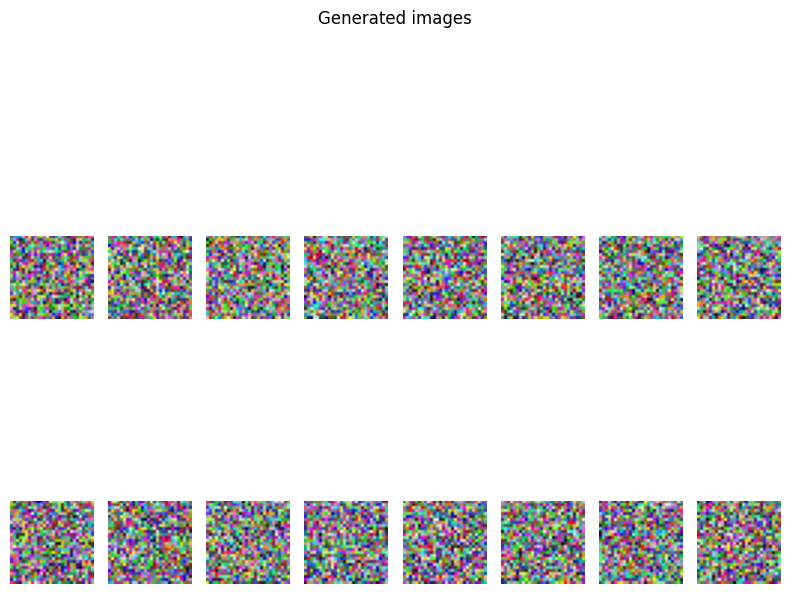

In [61]:
show_images(generated, "Generated images")

## Algorithm

In [62]:
def algorithm_1(
    ddpm: Diffusion,
    loader,
    n_epochs,
    optim,
    display=False,
    store_model="models/ddpm.pt",
):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    with mlflow.start_run(log_system_metrics=True):
        mlflow.log_params(
            {
                "n_epochs": n_epochs,
                "n_steps": n_steps,
            }
        )

        for epoch in tqdm(range(n_epochs), desc=f"Training progress"):
            epoch_loss = 0.0
            for step, batch in enumerate(
                tqdm(loader, desc=f"Epoch {epoch}/{n_epochs}")
            ):
                # Load batch
                x0 = batch[0].to(device)
                n = len(x0)

                # Pick noise
                eta = torch.randn_like(x0)
                t = torch.randint(0, n_steps, (n,))

                # Forward pass
                noisy_imgs = ddpm(x0, t, eta)

                # Get model prediction of added noise
                eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

                # Compute loss
                loss = mse(eta_theta, eta)
                optim.zero_grad()
                loss.backward()
                optim.step()

                mlflow.log_metric("loss", loss.item(), step=epoch * len(loader) + step)

                # Store average loss for the epoch
                epoch_loss += (loss.item() * n) / len(loader.dataset)

            mlflow.log_metric("epoch_loss", epoch_loss, step=epoch)

            if display:
                show_images(generate_new_images(ddpm, n_samples=4), f"Epoch {epoch}")

            print(f"Epoch {epoch}/{n_epochs} - Loss: {epoch_loss:.4f}")
            if best_loss > epoch_loss:
                best_loss = epoch_loss
                torch.save(ddpm.state_dict(), store_model)

                print(
                    f"New best model saved with loss: {best_loss:.4f} at epoch {epoch}"
                )
                mlflow.log_artifact(store_model)
                mlflow.log_metric("best_loss", best_loss, step=epoch)

In [63]:
mlflow.set_experiment("ddpm-celeba")
algorithm_1(
    ddpm,
    loader,
    n_epochs=10,
    optim=torch.optim.Adam(ddpm.parameters(), lr=0.001),
    display=False,
)


2024/07/10 02:54:54 INFO mlflow.tracking.fluent: Experiment with name 'ddpm-celeba' does not exist. Creating a new experiment.
2024/07/10 02:54:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

: 

In [ ]:
best_model = Diffusion(
    UNet(n_steps=n_steps), min_beta=min_beta, max_beta=max_beta, n_steps=n_steps
)
best_model.load_state_dict(torch.load("models/ddpm.pt"))
best_model.eval()
print("Model loaded")


In [ ]:
show_images(
    generate_new_images(best_model, n_samples=16), "Generated images after training"
)